## Compare the ELFIN and THEMIS-A spectra during the 4 September 2022 substorm event.
Let's make a summary plot first.

In [1]:
import dateutil.parser
import pathlib
from datetime import datetime
import logging

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors
import pyspedas
import pytplot
import manylabels
import pandas as pd
import numpy as np

import elfinasi

logger = logging.getLogger()
logger.disabled = True

In [2]:
ELECTRON_CHARGE = 1.60217663E-19  # Coulombs
ELECTRON_MASS = 9.1093837E-31  # kg
PERMITTIVITY = 8.8541878188E-12	 # C^2⋅kg^−1⋅m^−3⋅s^2
SPEED_OF_LIGHT = 3E8 # ms/s
R_E = 6378.137  # km

## Load and analyze THEMIS probe spectra

In [3]:
time_range = ('2022-09-04T04:00', '2022-09-04T04:30')
_time_range = [dateutil.parser.parse(t_i) for t_i in time_range]
coordinates = 'gsm'
themis_probe = 'a'

themisa_spectra_time_ranges = (
    [datetime(2022, 9, 4, 4, 12, 0), datetime(2022, 9, 4, 4, 14, 0)],
    [datetime(2022, 9, 4, 4, 22, 0), datetime(2022, 9, 4, 4, 23, 0)],
)
themisd_spectra_time_ranges = (
    [datetime(2022, 9, 4, 4, 16, 0), datetime(2022, 9, 4, 4, 19, 0)],
    [datetime(2022, 9, 4, 4, 23, 0), datetime(2022, 9, 4, 4, 25, 0)],
)
themis_colors = plt.cm.viridis(np.linspace(0, 1, len(themisa_spectra_time_ranges)))

In [4]:
themis_probes = np.array(['a', 'd', 'e'])
themis_Ew = ('fff_32_edc34', 'fff_32_edc34', 'fff_32_edc12')[np.where(themis_probes==themis_probe)[0][0]]
themis_Bw = ('fff_32_scm3', 'fff_32_scm3', 'fff_32_scm3')[np.where(themis_probes==themis_probe)[0][0]]

In [5]:
fgm_vars = pyspedas.themis.fgm(probe=themis_probe, trange=time_range, time_clip=True, no_update=True)
sst_vars = pyspedas.themis.sst(probe=themis_probe, trange=time_range, time_clip=True, no_update=True)
mom_vars = pyspedas.themis.mom(probe=themis_probe, trange=time_range, time_clip=True, no_update=True)
fft_vars = pyspedas.themis.fft(probe=themis_probe, trange=time_range, time_clip=True, no_update=True)
state_vars = pyspedas.themis.state(probe=themis_probe, trange=time_range, time_clip=True, no_update=True)

fgm_xr = pytplot.get_data(f'th{themis_probe}_fgl_{coordinates}')
fgm_times = np.array([t_i.replace(tzinfo=None) for t_i in pyspedas.time_datetime(fgm_xr.times)])
vi_xr = pytplot.get_data(f'th{themis_probe}_peim_velocity_{coordinates}')
sst_xr = pytplot.get_data(f'th{themis_probe}_psef_en_eflux')
valid_sst_channels = np.where(~np.isnan(sst_xr.v[0, :]))[0]
ssta_times = np.array([t_i.replace(tzinfo=None) for t_i in pyspedas.time_datetime(sst_xr.times)])
ssta_spectrum = 1E6*sst_xr.y[:, valid_sst_channels]/sst_xr.v[0, valid_sst_channels]
bw_xr = pytplot.get_data(f'th{themis_probe}_{themis_Bw}')
ew_xr = pytplot.get_data(f'th{themis_probe}_{themis_Ew}')


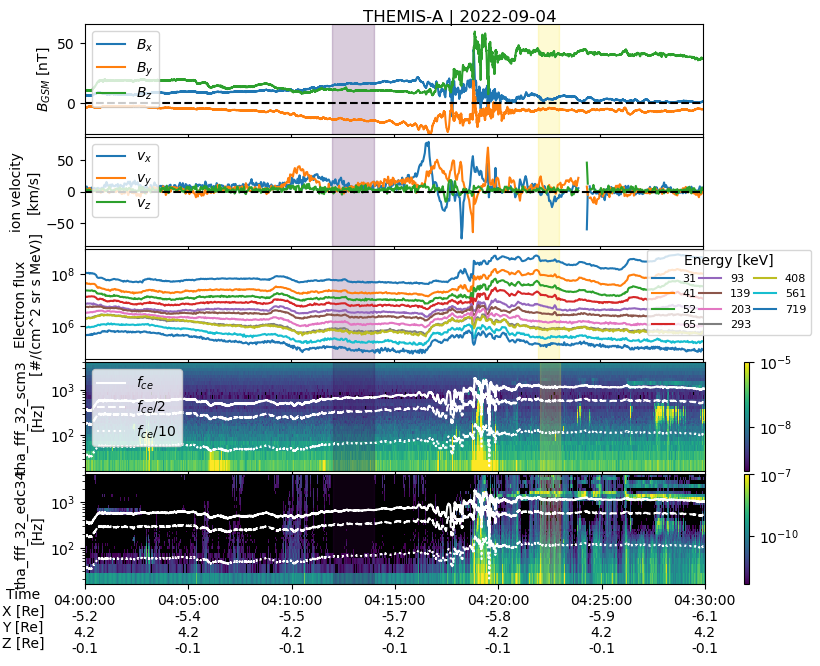

In [6]:
fig, ax = plt.subplots(5, sharex=True, figsize=(10, 7))

_lines = ax[0].plot(fgm_times, fgm_xr.y)
ax[0].legend(iter(_lines), [f'$B_{{{i}}}$' for i in ['x', 'y', 'z']], loc='upper left')
ax[0].axhline(0, c='k', ls='--')
ax[0].set(
    ylim=(-25, 1.1*np.max(fgm_xr.y)), 
    ylabel=f'$B_{{{coordinates.upper()}}}$ [nT]',
    xlim=_time_range
    )

_lines = ax[1].plot(pyspedas.time_datetime(vi_xr.times), vi_xr.y)
ax[1].legend(iter(_lines), [f'$v_{{{i}}}$' for i in [f'x', 'y', 'z']], loc='upper left')
ax[1].axhline(0, c='k', ls='--')
ax[1].set(ylim=(-1.1*np.nanmax(vi_xr.y), 1.1*np.nanmax(vi_xr.y)), ylabel='ion velocity\n[km/s]')

for valid_e_channel in valid_sst_channels:
    ax[2].plot(
        ssta_times, 
        ssta_spectrum[:, valid_e_channel], 
        label=int(sst_xr.v[0, valid_e_channel]/1000)
        )
ax[2].set(yscale='log', ylabel='Electron flux\n[#/(cm^2 sr s MeV)]')
ax[2].legend(fontsize=8, ncols=3, title='Energy [keV]', loc='upper left', bbox_to_anchor=(0.9, 1.05), columnspacing=0.2)

p = ax[3].pcolormesh(
    np.array(pyspedas.time_datetime(bw_xr.times)), 
    bw_xr.v, 
    bw_xr.y.T, 
    norm=matplotlib.colors.LogNorm(vmax=1E-5),
    shading='nearest'
    )
plt.colorbar(p, ax=ax[3])
ax[3].set(yscale='log', ylabel=f'th{themis_probe}_{themis_Bw}\n[Hz]')    
f_ce = np.abs(ELECTRON_CHARGE)*1E-9*np.linalg.norm(fgm_xr.y, axis=1)/(2*np.pi*ELECTRON_MASS)

p = ax[4].pcolormesh(
    pyspedas.time_datetime(ew_xr.times), 
    ew_xr.v, 
    ew_xr.y.T, 
    norm=matplotlib.colors.LogNorm(vmax=1E-7)
    )
plt.colorbar(p, ax=ax[4])
ax[4].set(yscale='log', ylabel=f'th{themis_probe}_{themis_Ew}\n[Hz]')

for ax_i in ax[3:]:
    ax_i.plot(pyspedas.time_datetime(fgm_xr.times), f_ce, label=f'$f_{{ce}}$', c='w', ls='-')
    ax_i.plot(pyspedas.time_datetime(fgm_xr.times), f_ce/2, label=f'$f_{{ce}}/2$', c='w', ls='--')
    ax_i.plot(pyspedas.time_datetime(fgm_xr.times), f_ce/10, label=f'$f_{{ce}}/10$', c='w', ls=':')
    ax_i.set_facecolor('k')
ax[3].legend(loc='upper left')

plt.suptitle(f'THEMIS-{themis_probe.upper()} | {time_range[0][:10]}')

state_xr = pytplot.get_data(f'th{themis_probe}_pos_{coordinates}')
state_times = pyspedas.time_datetime(state_xr.times)
state_times = [state_time.replace(tzinfo=None) for state_time in state_times]
state_df = pd.DataFrame(
    index=state_times,
    data={f'{component.upper()} [Re]':state_xr.y[:, i]/R_E for i, component in enumerate(['x', 'y', 'z'])}
    )
manylabels.ManyLabels(ax[-1], state_df)

for ax_i in ax[:3]:
    divider = make_axes_locatable(ax_i)
    cax = divider.append_axes("right", size="24%", pad=0.08)
    cax.remove()
plt.subplots_adjust(hspace=0.03, top=0.959)

for themis_spectra_time_range, color in zip(themisa_spectra_time_ranges, themis_colors):
    for ax_i in ax:
        ax_i.axvspan(*themis_spectra_time_range, color=color, alpha=0.2)

What fraction of the total field was Bz before and after the dipolarization?

In [7]:
for i, themis_time_range in enumerate(themisa_spectra_time_ranges):
    idx = np.where((np.array(fgm_times)>=themis_time_range[0]) & (np.array(fgm_times)<=themis_time_range[1]))[0]
    mean_b = fgm_xr.y[idx, :].mean(axis=0)
    mean_bxy = fgm_xr.y[idx, 1:].mean(axis=0)
    
    print(
        f'{themis_time_range=}\n|B| = {np.linalg.norm(mean_b) :.2f} nT,'
        f'|Bz|/|B| = {mean_b[-1]/np.linalg.norm(mean_b) :.2f}, '
        f'|Bz|/|Bxy| = {mean_b[-1]/np.linalg.norm(mean_bxy) :.2f}\n'
        )

themis_time_range=[datetime.datetime(2022, 9, 4, 4, 12), datetime.datetime(2022, 9, 4, 4, 14)]
|B| = 23.59 nT,|Bz|/|B| = 0.46, |Bz|/|Bxy| = 0.62

themis_time_range=[datetime.datetime(2022, 9, 4, 4, 22), datetime.datetime(2022, 9, 4, 4, 23)]
|B| = 40.87 nT,|Bz|/|B| = 0.99, |Bz|/|Bxy| = 0.99



# Calc THEMIS Spectra

In [8]:
fgm_times = np.array([t_i.replace(tzinfo=None) for t_i in pyspedas.time_datetime(fgm_xr.times)])
bidx_before = np.where(
    (fgm_times>=themisa_spectra_time_ranges[0][0]) & 
    (fgm_times<=themisa_spectra_time_ranges[0][1])
    )[0]
bidx_after = np.where(
    (fgm_times>=themisa_spectra_time_ranges[-1][0]) & 
    (fgm_times<=themisa_spectra_time_ranges[-1][1])
    )[0]
mag_b = np.linalg.norm(fgm_xr.y, axis=1)
mean_b_before = mag_b[bidx_before].mean()
mean_b_after = mag_b[bidx_after].mean()
print(f'B field before: {mean_b_before} and after: {mean_b_after}.')

B field before: 23.604307174682617 and after: 40.87730407714844.


In [9]:
themis_spectra_mean = np.full((len(themisa_spectra_time_ranges), len(sst_xr.v[0, valid_sst_channels])), np.nan)
themis_spectra_iqr = np.full((len(themisa_spectra_time_ranges), 2, len(sst_xr.v[0, valid_sst_channels])), np.nan)
for i, themis_spectra_time_range in enumerate(themisa_spectra_time_ranges):
    idx = np.where(
        (ssta_times>=themis_spectra_time_range[0]) & 
        (ssta_times<=themis_spectra_time_range[1])
        )[0]
    themis_spectra_mean[i, :] = np.mean(ssta_spectrum[idx, :], axis=0)
    themis_spectra_iqr[i, ...] = np.quantile(ssta_spectrum[idx, :], (0.25, 0.75), axis=0)

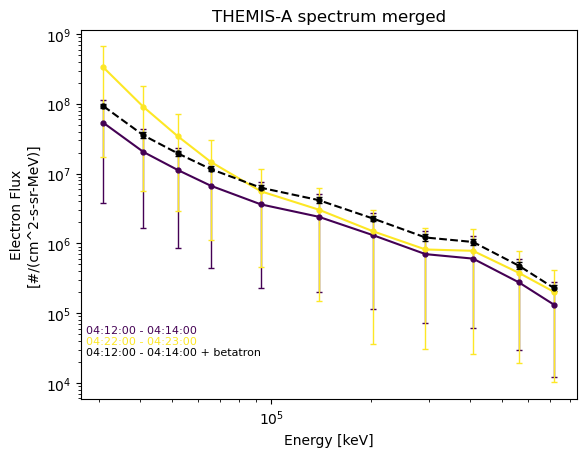

In [10]:
fig, ax = plt.subplots()
for i, (themis_time_range, color) in enumerate(zip(themisa_spectra_time_ranges, themis_colors)):
    ax.errorbar(sst_xr.v[0, valid_sst_channels],  themis_spectra_mean[i, :], color=color, yerr=themis_spectra_iqr[i, ...], capsize=2,
            markersize=7, elinewidth=1, marker='.', ls='-')
    ax.text(
        0.01, 0.2-0.03*i, f'{themis_time_range[0]:%H:%M:%S} - {themis_time_range[1]:%H:%M:%S}', 
        fontsize=8, transform=ax.transAxes, va='top', ha='left', color=color
        )
    
ax.errorbar(
    sst_xr.v[0, valid_sst_channels],  
    (mean_b_after/mean_b_before)*themis_spectra_mean[0, :], 
    color='k', 
    yerr=(mean_b_after/mean_b_before)*np.abs(themis_spectra_mean[0, :]-themis_spectra_iqr[0, :]), 
    capsize=2,
    markersize=7, 
    elinewidth=1, 
    marker='.', 
    ls='--'
    )
ax.text(
        0.01, 0.2-0.03*(i+1), f'{themisa_spectra_time_ranges[0][0]:%H:%M:%S} - {themisa_spectra_time_ranges[0][1]:%H:%M:%S} + betatron', 
        fontsize=8, transform=ax.transAxes, va='top', ha='left', color='k'
        )

ax.set(xlabel='Energy [keV]', yscale='log', xscale='log', title='THEMIS-A spectrum merged')
ax.set_ylabel(f'Electron Flux\n[#/(cm^2-s-sr-MeV)]');

So it looks like betatron acceleration does not explain the increase in the fluxes. This seems like an injection!

## Load and analyze ELFIN spectra

In [11]:
elfin_spectra_time_ranges = (
    [datetime(2022, 9, 4, 4, 18, 3), datetime(2022, 9, 4, 4, 20, 5)],
    [datetime(2022, 9, 4, 4, 20, 5), datetime(2022, 9, 4, 4, 20, 25)],
    [datetime(2022, 9, 4, 4, 20, 25), datetime(2022, 9, 4, 4, 21, 20)],
)
elfin_colors = plt.cm.jet(np.linspace(0, 1, len(elfin_spectra_time_ranges)))

In [12]:
elfin_probe = 'a'
pad_obj = elfinasi.EPD_PAD(
    elfin_probe, time_range, start_pa=0, min_counts=None, accumulate=1, spin_time_tol=(2.5, 12),
    lc_exclusion_angle=0
)
transformed_state = pad_obj.transform_state()

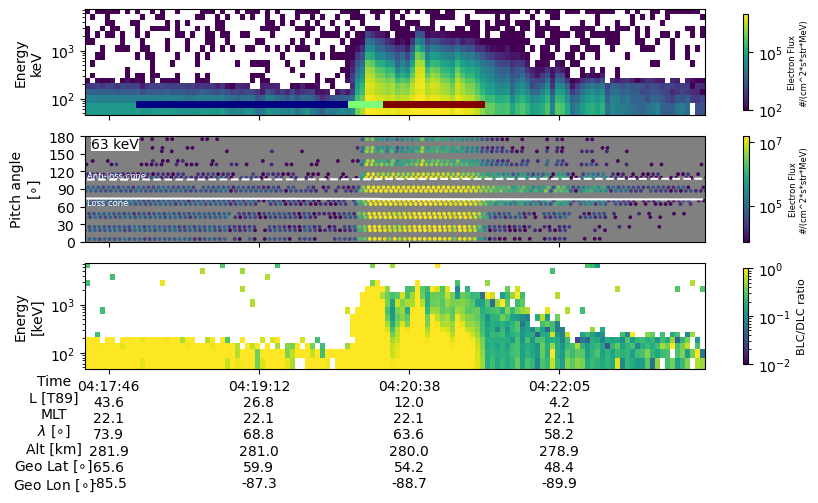

In [13]:

fig, cx = plt.subplots(3, 1, sharex=True, figsize=(10, 6))

# transformed_state = transformed_state.loc[time_range[0]:time_range[1]]
pad_obj.plot_omni(cx[0], labels=True, colorbar=True, vmin=1E2, vmax=1E7, pretty_plot=False)
pad_obj.plot_pad_scatter(cx[1])
pad_obj.plot_blc_dlc_ratio(cx[2], labels=True, colorbar=True, cmap='viridis', vmin=1E-2, vmax=1)
pad_obj.plot_position(cx[2])
cx[2].xaxis.set_major_locator(plt.MaxNLocator(5))
cx[2].xaxis.set_label_coords(-0.05, -0.007*7)
cx[2].xaxis.label.set_size(10)
for elfin_spectra_time_range, color in zip(elfin_spectra_time_ranges, elfin_colors):
    mixed_transform = transforms.blended_transform_factory(cx[0].transData, cx[0].transAxes)
    cx[0].plot(
        [elfin_spectra_time_range[0], elfin_spectra_time_range[1]], [0.1,0.1], color=color, alpha=1, transform=mixed_transform, linewidth=5
        )

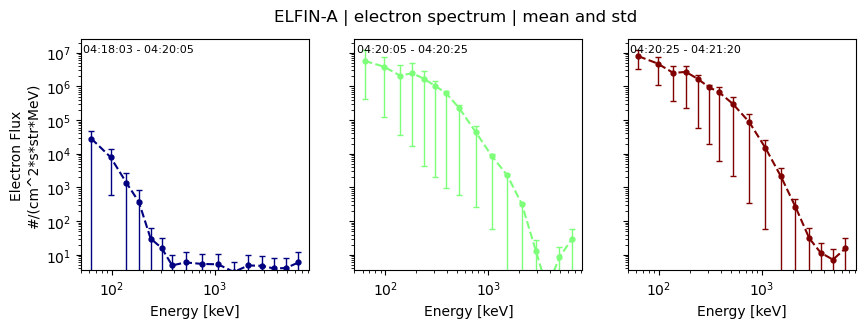

In [14]:
fig, dx = plt.subplots(1, len(elfin_spectra_time_ranges), figsize=(10, 3), sharey=True, sharex=True)

elfin_spectra_mean = np.nan*np.zeros((len(elfin_spectra_time_ranges), pad_obj.energy.shape[0]))
elfin_spectra_iqr = np.nan*np.zeros((len(elfin_spectra_time_ranges), 2, pad_obj.energy.shape[0]))

for i, (elfin_spectra_time_range, dx_i, color) in enumerate(zip(elfin_spectra_time_ranges, dx, elfin_colors)):
    pad_flt = pad_obj.pad.sel(time=slice(elfin_spectra_time_range[0], elfin_spectra_time_range[1]))
    elfin_spectra_mean[i, :] = pad_flt.mean(dim=('time', 'pa'), skipna=True).sel(energy=pad_obj._flux_keys)
    elfin_spectra_iqr[i, ...] = pad_flt.quantile((0.25, 0.75), dim=('time', 'pa'), skipna=True).sel(energy=pad_obj._flux_keys)
    dx_i.errorbar(pad_obj.energy, elfin_spectra_mean[i, :], color=color, yerr=np.abs(elfin_spectra_mean[i, :]-elfin_spectra_iqr[i, :]), capsize=2,
            markersize=7, elinewidth=1, marker='.', ls='--')
    dx_i.set(xlabel='Energy [keV]', yscale='log', xscale='log')
    dx_i.text(
        0.01, 0.98, f'{elfin_spectra_time_range[0]:%H:%M:%S} - {elfin_spectra_time_range[1]:%H:%M:%S}', 
        fontsize=8, transform=dx_i.transAxes, va='top'
        )
dx[0].set_ylabel(f'Electron Flux\n{pad_obj._flux_units}')
plt.suptitle(f'ELFIN-{themis_probe.upper()} | electron spectrum | mean and std');

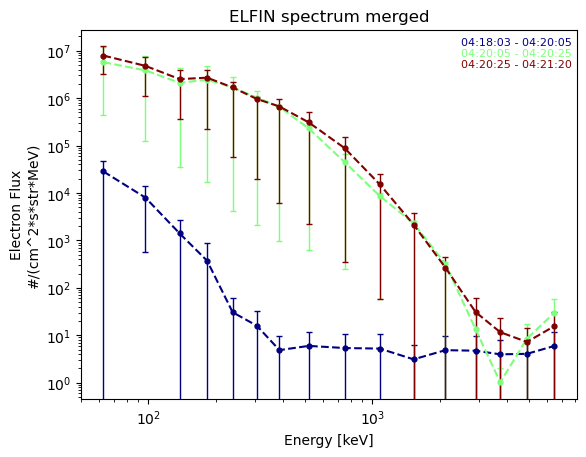

In [15]:
fig, ax = plt.subplots()
for i, (elfin_spectra_time_range, color) in enumerate(zip(elfin_spectra_time_ranges, elfin_colors)):
    ax.errorbar(pad_obj.energy, elfin_spectra_mean[i, :], color=color, yerr=np.abs(elfin_spectra_mean[i, :]-elfin_spectra_iqr[i, :]), capsize=2,
            markersize=7, elinewidth=1, marker='.', ls='--')
    ax.text(
        0.99, 0.98-0.03*i, f'{elfin_spectra_time_range[0]:%H:%M:%S} - {elfin_spectra_time_range[1]:%H:%M:%S}', 
        fontsize=8, transform=ax.transAxes, va='top', ha='right', color=color
        )

ax.set(xlabel='Energy [keV]', yscale='log', xscale='log', title='ELFIN spectrum merged')
ax.set_ylabel(f'Electron Flux\n{pad_obj._flux_units}');
    

Both the IB and chorus-driven spectrum are essentially the same. Now let's make a similar plot, but this time fix the x- and y-axis range, and change units slightly.

This is to address the reviewer feedback.

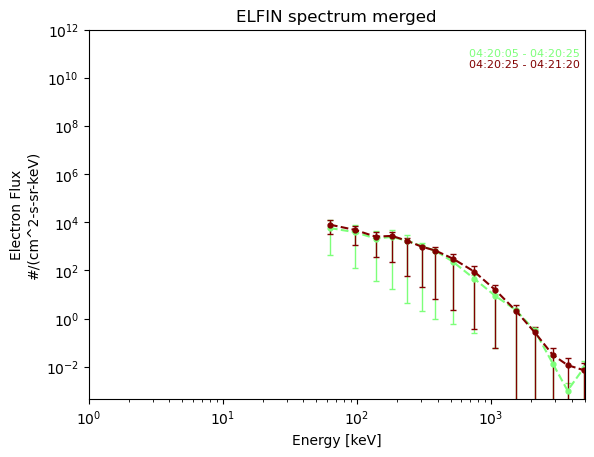

In [16]:
# %matplotlib tk
fig, ax = plt.subplots()
for i, (elfin_spectra_time_range, color) in enumerate(zip(elfin_spectra_time_ranges, elfin_colors)):
    if elfin_spectra_time_range[0] < datetime(2022, 9, 4, 4, 20, 5):
        # Skip the PS spectrum.
        continue
    ax.errorbar(
        pad_obj.energy, 
        elfin_spectra_mean[i, :]/1e3, 
        color=color, 
        yerr=np.abs(elfin_spectra_mean[i, :]-elfin_spectra_iqr[i, :])/1e3, 
        capsize=2,
        markersize=7, 
        elinewidth=1, 
        marker='.', 
        ls='--'
        )
    ax.text(
        0.99, 0.98-0.03*i, f'{elfin_spectra_time_range[0]:%H:%M:%S} - {elfin_spectra_time_range[1]:%H:%M:%S}', 
        fontsize=8, transform=ax.transAxes, va='top', ha='right', color=color
        )

ax.set(xlabel='Energy [keV]', yscale='log', xscale='log', title='ELFIN spectrum merged', xlim=(1, 5_000), ylim=(None, 1e12))
ax.set_ylabel(f'Electron Flux\n#/(cm^2-s-sr-keV)');

## Compare the ELFIN and THEMIS spectra in a grid-form

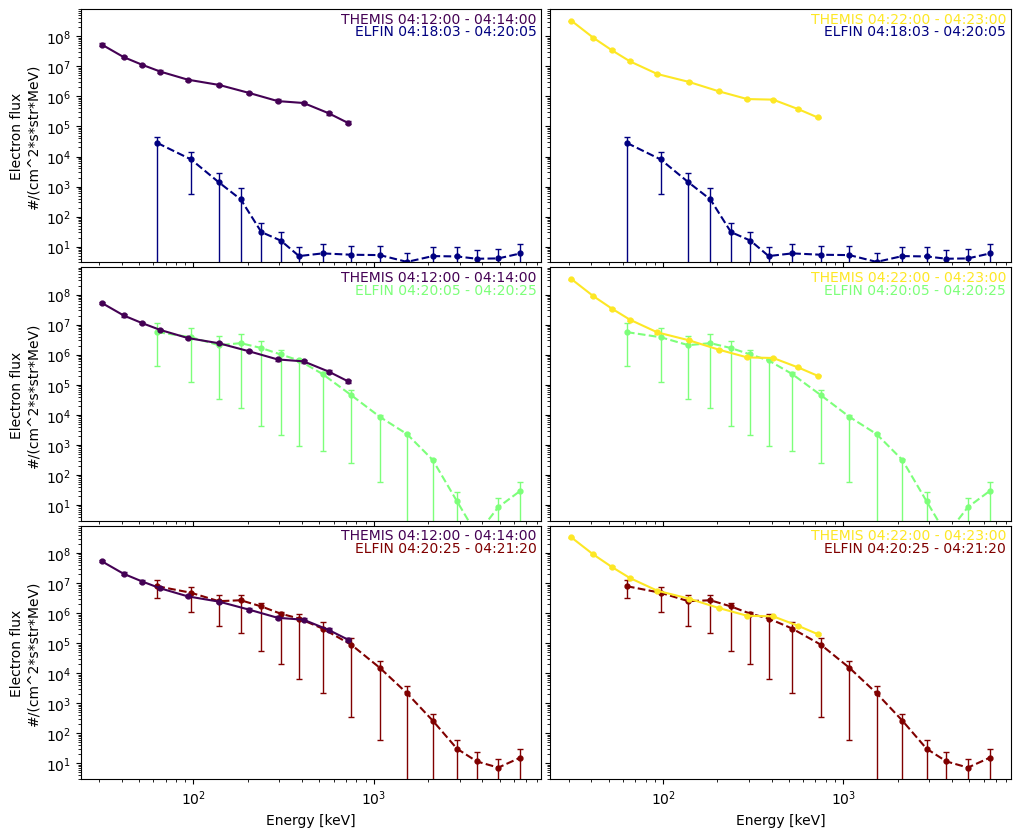

In [17]:
fig, ex = plt.subplots(len(elfin_spectra_time_ranges), len(themisa_spectra_time_ranges), sharex=True, sharey=True, figsize=(12, 10))

for i, (ex_row, elfin_color) in enumerate(zip(ex, elfin_colors)):
    for j, (ex_col, themis_color) in enumerate(zip(ex_row, themis_colors)):
        ex_col.errorbar(
            pad_obj.energy, 
            elfin_spectra_mean[i, :], 
            color=elfin_color, 
            yerr=np.abs(elfin_spectra_mean[i, :]-elfin_spectra_iqr[i, :]), 
            capsize=2,
            markersize=7, 
            elinewidth=1, 
            marker='.', 
            ls='--'
            )
        ex_col.errorbar(
            sst_xr.v[0, valid_sst_channels]/1E3,  
            themis_spectra_mean[j, :], 
            color=themis_color, 
            yerr=np.abs(themis_spectra_mean[j, :] - themis_spectra_iqr[j, ...]), 
            capsize=2,
            markersize=7, elinewidth=1, marker='.', ls='-')
        ex_col.set(yscale='log', xscale='log')
        ex_col.text(
            0.99, 0.99, 
            f'THEMIS {themisa_spectra_time_ranges[j][0]:%H:%M:%S} - {themisa_spectra_time_ranges[j][1]:%H:%M:%S}', 
            va='top', ha='right', transform=ex_col.transAxes, color=themis_color)
        ex_col.text(
            0.99, 0.94, 
            f'ELFIN {elfin_spectra_time_ranges[i][0]:%H:%M:%S} - {elfin_spectra_time_ranges[i][1]:%H:%M:%S}', 
            va='top', ha='right', transform=ex_col.transAxes, color=elfin_color)
for ex_i in ex[-1, :]:
    ex_i.set_xlabel('Energy [keV]')
for ex_i in ex[:, 0]:
    ex_i.set_ylabel(f'Electron flux\n{pad_obj._flux_units}')
plt.subplots_adjust(wspace=0.02, hspace=0.02)

13-Jun-25 12:51:50: C:\Users\shumkms1\AppData\Local\Temp\ipykernel_26784\3195190771.py:48: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for _obj in _legend.legendHandles:



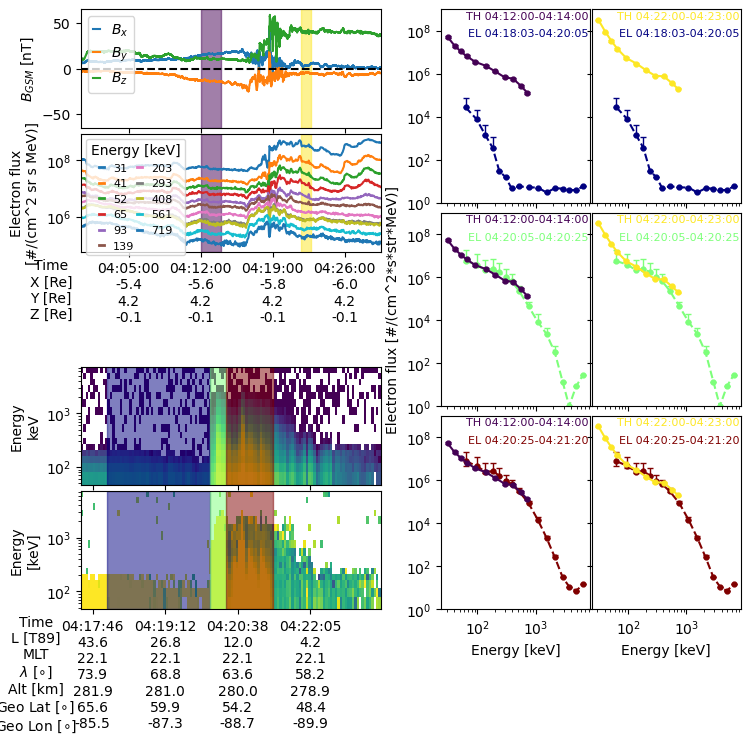

In [22]:
spec_fig = plt.figure(figsize=(12, 10))
gs = spec_fig.add_gridspec(4, len(themisa_spectra_time_ranges)+2, hspace=1.8, right=0.95, left=0.4, wspace=0.5)
themis_gs = gs[:2, :2].subgridspec(2, 1, wspace=0.05, hspace=0.05)
elfin_gs = gs[2:4, :2].subgridspec(2, 1, wspace=0.01, hspace=0.05)
spec_grid = gs[:, 2:].subgridspec(len(elfin_spectra_time_ranges), len(themisa_spectra_time_ranges), wspace=0.01, hspace=0.05)

ax = [None]*4
ax[0] = spec_fig.add_subplot(themis_gs[0,:])
ax[1] = spec_fig.add_subplot(themis_gs[1,:], sharex=ax[0])
ax[2] = spec_fig.add_subplot(elfin_gs[0,:])
ax[3] = spec_fig.add_subplot(elfin_gs[1,:], sharex=ax[2])

bx = np.full((len(elfin_spectra_time_ranges), len(themisa_spectra_time_ranges)), np.nan, dtype=object)
for row in range(len(elfin_spectra_time_ranges)):
    for col in range(len(themisa_spectra_time_ranges)):
        if (row == 0) and (col == 0):
            bx[row, col] = spec_fig.add_subplot(spec_grid[row, col])
        else:
            bx[row, col] = spec_fig.add_subplot(spec_grid[row, col], sharex=bx[0, 0], sharey=bx[0, 0])

        if row != len(themisa_spectra_time_ranges):
            bx[row, col].tick_params('x', labelbottom=False)
        if col > 0:
            bx[row, col].tick_params('y', labelleft=False)

# PLOT THEMIS
_lines = ax[0].plot(pyspedas.time_datetime(fgm_xr.times), fgm_xr.y)
ax[0].legend(iter(_lines), [f'$B_{{{i}}}$' for i in ['x', 'y', 'z']], loc='upper left', bbox_to_anchor=(0, 1), handlelength=0.5)
ax[0].axhline(0, c='k', ls='--')
ax[0].set(
    ylim=(-1.1*np.max(fgm_xr.y), 1.1*np.max(fgm_xr.y)), 
    ylabel=f'$B_{{{coordinates.upper()}}}$ [nT]',
    xlim=_time_range
    )
ax[0].tick_params('x', labelbottom=False)

for valid_e_channel in valid_sst_channels:
    ax[1].plot(
        ssta_times, 
        ssta_spectrum[:, valid_e_channel], 
        label=int(sst_xr.v[0, valid_e_channel]/1000)
        )
ax[1].set(yscale='log', ylabel='Electron flux\n[#/(cm^2 sr s MeV)]')
_legend = ax[1].legend(
    fontsize=8, ncols=2, title='Energy [keV]', loc='upper left', bbox_to_anchor=(0, 1), columnspacing=0.2,
    handlelength=0.5
    )
for _obj in _legend.legendHandles:
    _obj.set_linewidth(2)
manylabels.ManyLabels(ax[1], state_df)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(5))
ax[1].xaxis.set_label_coords(-0.1, -0.008*7)

for themis_spectra_time_range, color in zip(themisa_spectra_time_ranges, themis_colors):
    for ax_i in ax[:2]:
        ax_i.axvspan(*themis_spectra_time_range, color=color, alpha=0.5)

# PLOT ELFIN
pad_obj.plot_omni(ax[2], labels=True, vmin=1E2, vmax=1E7, pretty_plot=False, colorbar=False)
pad_obj.plot_blc_dlc_ratio(ax[3], labels=True, cmap='viridis', vmin=1E-2, vmax=1, colorbar=False)
pad_obj.plot_position(ax[3])
ax[2].tick_params('x', labelbottom=False)
ax[3].xaxis.set_major_locator(plt.MaxNLocator(5))
ax[3].xaxis.set_label_coords(-0.15, -0.007*7)
ax[3].xaxis.label.set_size(10)
    
for elfin_spectra_time_range, color in zip(elfin_spectra_time_ranges, elfin_colors):
    for ax_i in ax[2:4]:
        ax_i.axvspan(*elfin_spectra_time_range, color=color, alpha=0.5)

# Plot the spectra matrix
for i, (bx_row, elfin_color) in enumerate(zip(bx, elfin_colors)):
    for j, (bx_col, themis_color) in enumerate(zip(bx_row, themis_colors)):
        bx_col.errorbar(pad_obj.energy, elfin_spectra_mean[i, :], color=elfin_color, yerr=elfin_spectra_iqr[i, :], capsize=2,
            markersize=7, elinewidth=1, marker='.', ls='--')
        bx_col.errorbar(
            sst_xr.v[0, valid_sst_channels]/1E3,  
            themis_spectra_mean[j, :], 
            color=themis_color, 
            yerr=np.abs(themis_spectra_mean[j, :] - themis_spectra_iqr[j, ...]), 
            capsize=2,
            markersize=7, 
            elinewidth=1, 
            marker='.', 
            ls='-'
            )
        bx_col.set(yscale='log', xscale='log')
        bx_col.text(
            0.99, 0.99, 
            f'TH {themisa_spectra_time_ranges[j][0]:%H:%M:%S}-{themisa_spectra_time_ranges[j][1]:%H:%M:%S}', 
            va='top', ha='right', transform=bx_col.transAxes, color=themis_color, size=8)
        bx_col.text(
            0.99, 0.9, 
            f'EL {elfin_spectra_time_ranges[i][0]:%H:%M:%S}-{elfin_spectra_time_ranges[i][1]:%H:%M:%S}', 
            va='top', ha='right', transform=bx_col.transAxes, color=elfin_color, size=8)
for bx_col in bx[-1, :]:
    bx_col.set_xlabel('Energy [keV]')
# for bx_col in bx[:, 0]:
bx[1, 0].set_ylabel(f'Electron flux [{pad_obj._flux_units}]')
bx[0,0].set_ylim(1E0, 1E9);

## Now let's do the same thing with THEMIS-D

In [19]:
fgmd_vars = pyspedas.themis.fgm(probe='d', trange=time_range, time_clip=True, no_update=True)
sstd_vars = pyspedas.themis.sst(probe='d', trange=time_range, time_clip=True, no_update=True)
assert (fgmd_vars is not None) and (sstd_vars is not None) 

In [20]:
fgmd_xr = pytplot.get_data(f'thd_fgl_{coordinates}')
fgmd_times = np.array([t_i.replace(tzinfo=None) for t_i in pyspedas.time_datetime(fgm_xr.times)])
sstd_xr = pytplot.get_data(f'thd_psef_en_eflux')
valid_sst_channels = np.where(~np.isnan(sstd_xr.v[0, :]))[0]
sstd_times = np.array([t_i.replace(tzinfo=None) for t_i in pyspedas.time_datetime(sstd_xr.times)])
sstd_spectrum = 1E6*sstd_xr.y[:, valid_sst_channels]/sstd_xr.v[0, valid_sst_channels]

13-Jun-25 12:47:41: C:\Users\shumkms1\AppData\Local\Temp\ipykernel_26784\1830838945.py:45: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for _obj in _legend.legendHandles:



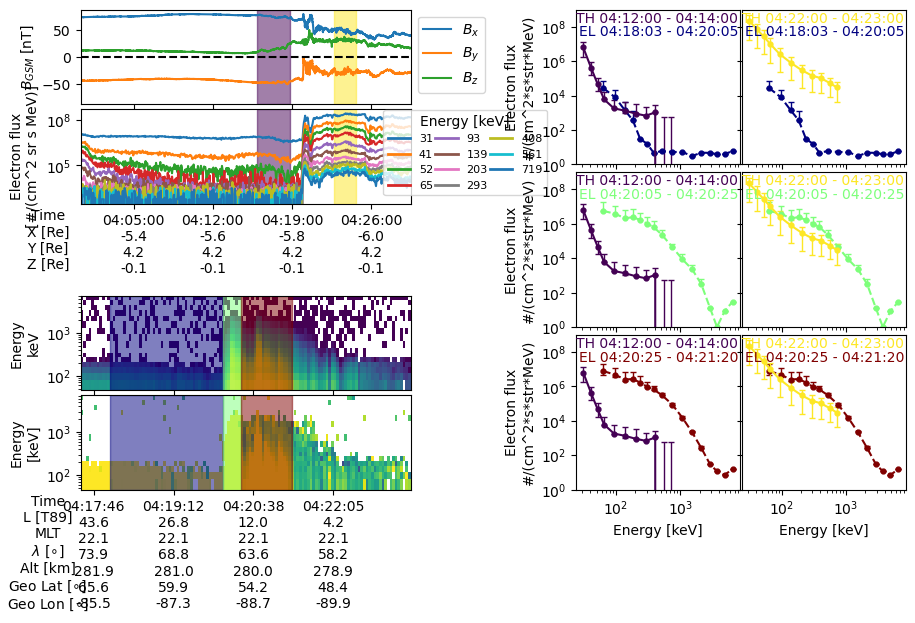

In [21]:
spec_fig = plt.figure(figsize=(15, 8))
gs = spec_fig.add_gridspec(4, len(themisd_spectra_time_ranges)+2, hspace=1.8, right=0.95, left=0.4, wspace=2)
themis_gs = gs[:2, :2].subgridspec(2, 1, wspace=0.05, hspace=0.05)
elfin_gs = gs[2:4, :2].subgridspec(2,1 , wspace=0.01, hspace=0.05)
spec_grid = gs[:, 2:].subgridspec(len(elfin_spectra_time_ranges), len(themisd_spectra_time_ranges), wspace=0.01, hspace=0.05)

ax = [None]*4
ax[0] = spec_fig.add_subplot(themis_gs[0,:])
ax[1] = spec_fig.add_subplot(themis_gs[1,:], sharex=ax[0])
ax[2] = spec_fig.add_subplot(elfin_gs[0,:])
ax[3] = spec_fig.add_subplot(elfin_gs[1,:], sharex=ax[2])

bx = np.full((len(elfin_spectra_time_ranges), len(themisd_spectra_time_ranges)), np.nan, dtype=object)
for row in range(len(elfin_spectra_time_ranges)):
    for col in range(len(themisd_spectra_time_ranges)):
        if (row == 0) and (col == 0):
            bx[row, col] = spec_fig.add_subplot(spec_grid[row, col])
        else:
            bx[row, col] = spec_fig.add_subplot(spec_grid[row, col], sharex=bx[0, 0], sharey=bx[0, 0])

        if row != len(themisa_spectra_time_ranges):
            bx[row, col].tick_params('x', labelbottom=False)
        if col > 0:
            bx[row, col].tick_params('y', labelleft=False)

# PLOT THEMIS
_lines = ax[0].plot(pyspedas.time_datetime(fgmd_xr.times), fgmd_xr.y)
ax[0].legend(iter(_lines), [f'$B_{{{i}}}$' for i in ['x', 'y', 'z']], loc='upper left', bbox_to_anchor=(1., 1))
ax[0].axhline(0, c='k', ls='--')
ax[0].set(
    ylim=(-1.1*np.max(fgmd_xr.y), 1.1*np.max(fgmd_xr.y)), 
    ylabel=f'$B_{{{coordinates.upper()}}}$ [nT]',
    xlim=_time_range
    )
ax[0].tick_params('x', labelbottom=False)

for valid_e_channel in valid_sst_channels:
    ax[1].plot(
        sstd_times, 
        sstd_spectrum[:, valid_e_channel], 
        label=int(sstd_xr.v[0, valid_e_channel]/1000)
        )
ax[1].set(yscale='log', ylabel='Electron flux\n[#/(cm^2 sr s MeV)]')
_legend = ax[1].legend(fontsize=8, ncols=3, title='Energy [keV]', loc='upper left', bbox_to_anchor=(0.9, 1.05), columnspacing=0.2)
for _obj in _legend.legendHandles:
    _obj.set_linewidth(2)
manylabels.ManyLabels(ax[1], state_df)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(5))
ax[1].xaxis.set_label_coords(-0.1, -0.008*7)

for themis_spectra_time_range, color in zip(themisd_spectra_time_ranges, themis_colors):
    for ax_i in ax[:2]:
        ax_i.axvspan(*themis_spectra_time_range, color=color, alpha=0.5)

# PLOT ELFIN
pad_obj.plot_omni(ax[2], labels=True, vmin=1E2, vmax=1E7, pretty_plot=False, colorbar=False)
pad_obj.plot_blc_dlc_ratio(ax[3], labels=True, cmap='viridis', vmin=1E-2, vmax=1, colorbar=False)
pad_obj.plot_position(ax[3])
ax[2].tick_params('x', labelbottom=False)
ax[3].xaxis.set_major_locator(plt.MaxNLocator(5))
ax[3].xaxis.set_label_coords(-0.1, -0.007*7)
ax[3].xaxis.label.set_size(10)
    
for elfin_spectra_time_range, color in zip(elfin_spectra_time_ranges, elfin_colors):
    for ax_i in ax[2:4]:
        ax_i.axvspan(*elfin_spectra_time_range, color=color, alpha=0.5)

# Plot the spectra matrix
for i, (bx_row, elfin_color) in enumerate(zip(bx, elfin_colors)):
    for j, (bx_col, themis_color, themis_spectra_time_range) in enumerate(zip(bx_row, themis_colors, themisd_spectra_time_ranges)):

        idx = np.where(
            (sstd_times>=themis_spectra_time_range[0]) & 
            (sstd_times<=themis_spectra_time_range[1])
            )[0]
        themisd_spectra_median = np.median(sstd_spectrum[idx, :], axis=0)
        themisd_spectra_iqr = np.nanquantile(sstd_spectrum[idx, :], (0.25, 0.75), axis=0)

        bx_col.errorbar(pad_obj.energy, elfin_spectra_mean[i, :], color=elfin_color, yerr=elfin_spectra_iqr[i, :], capsize=2,
            markersize=7, elinewidth=1, marker='.', ls='--')
        bx_col.errorbar(sstd_xr.v[0, valid_sst_channels]/1E3,  themisd_spectra_median, color=themis_color, yerr=themisd_spectra_iqr, capsize=2,
            markersize=7, elinewidth=1, marker='.', ls='-')
        bx_col.set(yscale='log', xscale='log')
        bx_col.text(
            0.99, 0.99, 
            f'TH {themisa_spectra_time_ranges[j][0]:%H:%M:%S} - {themisa_spectra_time_ranges[j][1]:%H:%M:%S}', 
            va='top', ha='right', transform=bx_col.transAxes, color=themis_color)
        bx_col.text(
            0.99, 0.9, 
            f'EL {elfin_spectra_time_ranges[i][0]:%H:%M:%S} - {elfin_spectra_time_ranges[i][1]:%H:%M:%S}', 
            va='top', ha='right', transform=bx_col.transAxes, color=elfin_color)
for bx_col in bx[-1, :]:
    bx_col.set_xlabel('Energy [keV]')
for bx_col in bx[:, 0]:
    bx_col.set_ylabel(f'Electron flux\n{pad_obj._flux_units}')
bx[0,0].set_ylim(1E0, 1E9);

# Takeaways:
1. THEMIS-A observed an electron spectrum that was consistent with ELFIN-A's RB or IB spectrum (there the RB/IB spectrum difference is negligible).
2. THEMIS-D observed an electron spectrum that was consistent with ELFIN-A's PS spectrum (although the spectrum deviates above 200 keV---is 10^3-10^4 the SST noise floor for > 200 keV channels?)